In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')

In [2]:
# General imports
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum

In [3]:
@dataclass
class SchedulerType(Enum):
    """The type of scheduler to use."""

    BASELINE = auto()
    SIMPLE = auto()
    EXTENDED = auto()  

In [4]:

# Find the type of algorithm
typeAlgorithm = os.listdir('component/d_scheduling/algorithm')
cleantypeAlgorithm = [item for item in typeAlgorithm if item not in ['__pycache__', '__init__.py']]
# make clean typeAlgorithm
dictAlgorithm = {}
for item in cleantypeAlgorithm:
    dictAlgorithm[item] = os.listdir('component/d_scheduling/algorithm/' + item)
    # make clean nameAlgorithm
    cleandictAlgorithm = [item for item in dictAlgorithm[item] if item not in ['__pycache__', '__init__.py']]
    dictAlgorithm[item] = cleandictAlgorithm

print(dictAlgorithm)


{'ilp': ['MILQ_extend', 'MILQ_simple'], 'ai': [], 'heuristic': []}


In [5]:
# Get list backend
from component.a_backend.backend_info import IBMQBackend
backend_list = [member.name for member in IBMQBackend]
print(backend_list)

['BELEM', 'NAIROBI', 'QUITO']


Show map backend

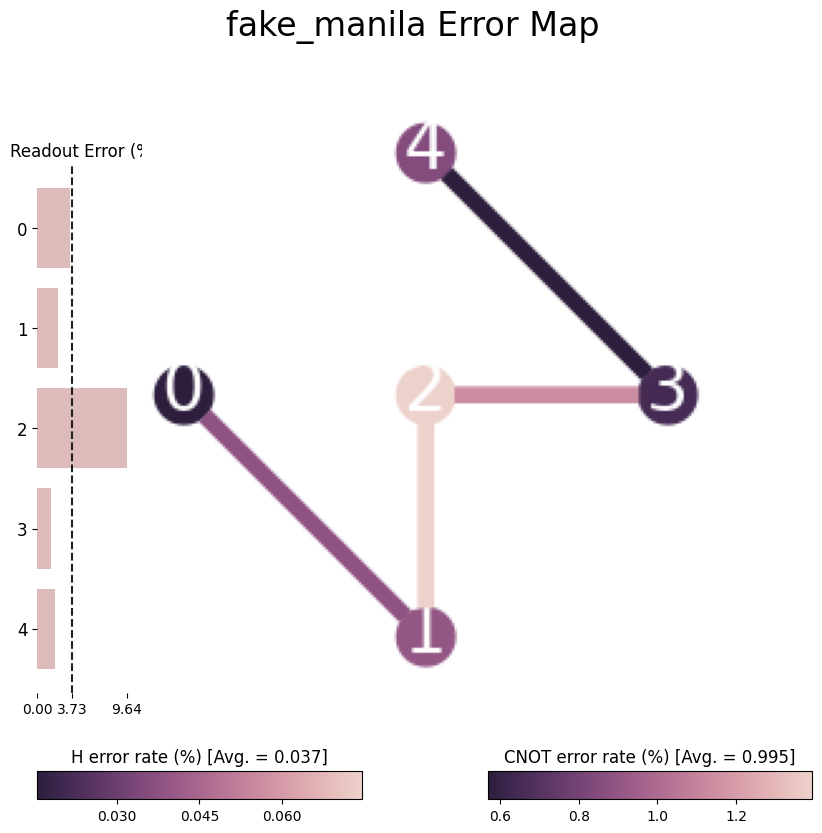

In [6]:
# Draw struct of backend
# using fakebackend or using aer simulator
from qiskit.visualization import plot_error_map, plot_gate_map
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
backend = FakeManilaV2()
plot_error_map(backend, figsize=(10,10))

Create benchmark

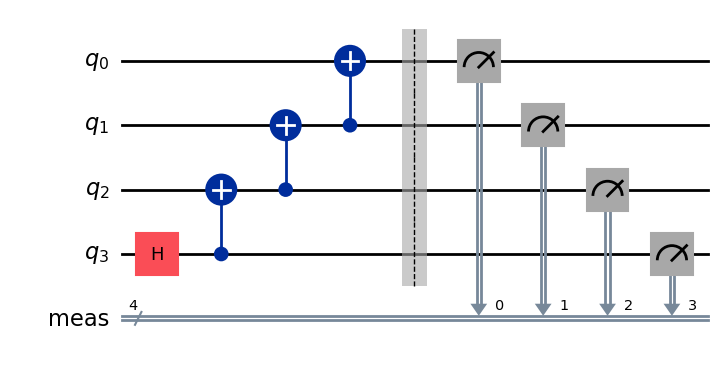

In [7]:
# create benchmark circuit
# Save the benchmark circuit to the disk(not yet) https://docs.quantum.ibm.com/guides/save-circuits

from component.b_benchmark.mqt_tool import benchmark_circuit

circuit = benchmark_circuit("ghz", 4)
circuit.draw("mpl")

Cutting circuit

In [8]:
from component.c_circuit_work.cutting.width_c import gate_to_reduce_width
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
resultCut = gate_to_reduce_width(circuit, "AABB")
subcircuits = resultCut.subcircuits
subobservables = resultCut.subobservables
bases = resultCut.bases

cal value from backend

In [9]:
from qiskit_addon_cutting import (
    cut_gates,
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)
from qiskit.transpiler import generate_preset_pass_manager

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}
from qiskit_ibm_runtime import SamplerV2, Batch
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=4096 * 3)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
 
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}
from qiskit_aer.primitives import EstimatorV2
# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
 
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
 
 
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(circuit, observable, [0.4] * len(circuit.parameters))])
    .result()[0]
    .data.evs
)
error_estimation = np.abs(reconstructed_expval - exact_expval)
relative_error_estimation = np.abs(
    (reconstructed_expval - exact_expval) / exact_expval
)

print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(error_estimation, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round(relative_error_estimation, 8))}"
)

Reconstructed expectation value: 0.90486961
Exact expectation value: 1.0
Error in estimation: 0.09513039
Relative error in estimation: 0.09513039


Apply scheduling to the benchmark circuits as require ment

In [10]:
# Configuration
# 1. Number of Jobs in the batch
jobs = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
# 2. Number of machines
machines = {"QUITO": 5, "BELEM": 5}

In [11]:
# Setup
bigM = 1000000
timesteps = 2**5

from component.d_scheduling.algorithm.ilp.MILQ_extend import MILQ_extend_implementation
# Scheduler
MILQ_extend_implementation.example_problem(bigM, timesteps, "component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/42062691d15640c88527d1978cc56baa-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/42062691d15640c88527d1978cc56baa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 710 COLUMNS
At line 4649 RHS
At line 5355 BOUNDS
At line 5860 ENDATA
Problem MODEL has 705 rows, 514 columns and 2929 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.24521 - 0.00 seconds
Cgl0002I 8 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 493 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 394 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 202 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 176 strengthened rows, 

  job  qubits machine  capacity  start   end  duration
0   A       2   QUITO         5    0.0  14.0      14.0
1   B       3   QUITO         5    0.0   8.0       8.0
2   C       5   BELEM         5    0.0  20.0      20.0
3   D       2   QUITO         5    9.0  21.0      12.0


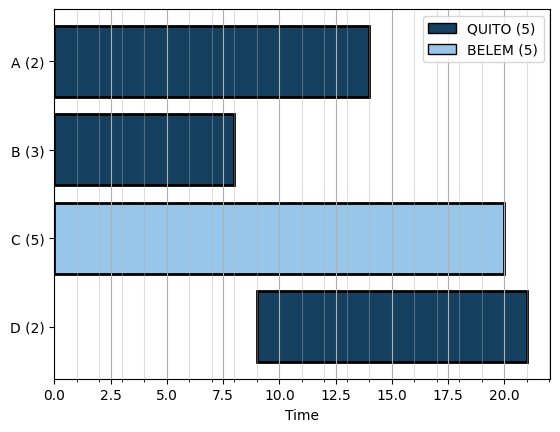

In [12]:
# Visualize
from component.d_scheduling.visualize import ilp

ilp.visualize("component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result.json")


Transpile the circuit with pass_manager

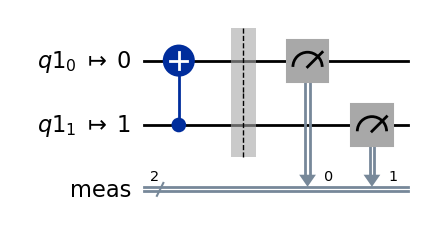

In [13]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager

subcircuits['A'].data = [hasChange for hasChange in subcircuits['A'].data if hasChange.operation.name != "qpd_1q"]
subcircuits['A'].measure_all()
target = backend.target
coupling_map = target.build_coupling_map()
pass_manager = generate_preset_pass_manager(
    optimization_level=3, coupling_map=coupling_map, seed_transpiler=12345
)
qc_t_cm_lv0 = pass_manager.run(subcircuits['A'])
qc_t_cm_lv0.draw("mpl", idle_wires=False, fold=-1)
 

Transpile the circuit with transpile only

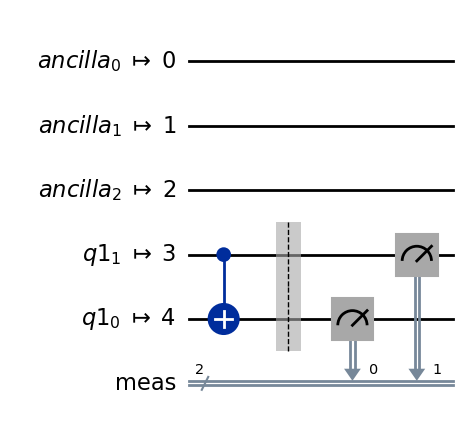

In [14]:
from qiskit import QuantumCircuit, transpile
transpiled_circuit = transpile(subcircuits['A'], backend)
transpiled_circuit.draw('mpl', style="iqp")

Plot transpiled circuit in backend

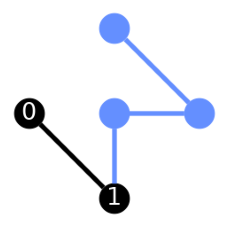

In [15]:
#mapping the scheduling result to the machine
# check qiskit_102, check qiskit transpiler

# after have the circuit we connect to
from qiskit.visualization import plot_circuit_layout
 
# Plot the hardware graph and indicate which hardware qubits were chosen to run the circuit
transpiled_circ = pass_manager.run(subcircuits['A'])
plot_circuit_layout(transpiled_circ, backend)

assemble the circuit to have the output in backend and ideal

{'00': 1024}


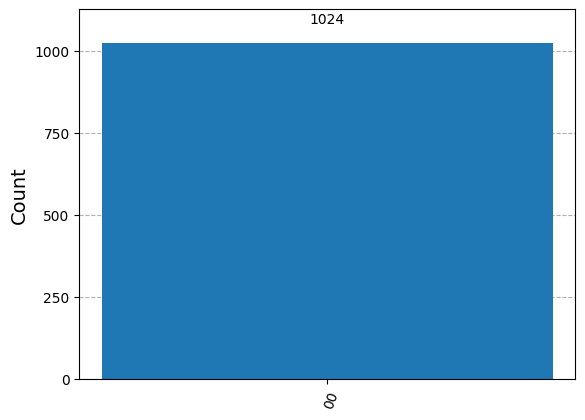

In [16]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

simulator_ideal = AerSimulator()
transpiled_circuit_ideal = transpile(subcircuits['A'], simulator_ideal)
transpiled_circuit_ideal.draw('mpl', style="iqp")
resultideal = simulator_ideal.run(subcircuits['A']).result()
counts_ideal = resultideal.get_counts(subcircuits['A'])
print(counts_ideal)
plot_histogram(counts_ideal)

reconstruct the circuit

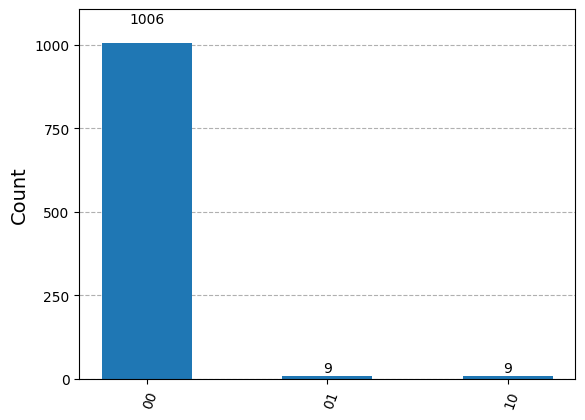

In [17]:
from qiskit_ibm_runtime import SamplerV2

samplerbackend = SamplerV2(backend)
job = samplerbackend.run([transpiled_circuit])
result_sim = job.result()[0]
counts_sim = result_sim.data.meas.get_counts()
plot_histogram(counts_sim)

In [ ]:
print(counts_sim)

{'00': 1006, '01': 9, '10': 9}


In [19]:
print(counts_ideal)

{'00': 1024}


In [26]:
len_matrix = max(len(counts_ideal), len(counts_sim))
print(len_matrix)

3


In [27]:
from qiskit.quantum_info import DensityMatrix, state_fidelity
import numpy as np

# Kết quả đếm của hai hệ thống
counts_ideal = {'00': 1024}
counts_sim = {'00': 1006, '01': 9, '10': 9}

# Tổng số lần đo cho mỗi hệ thống
total_count = sum(counts_ideal.values())  # Có thể dùng sum(counts_sim.values()) nếu muốn

# Tính toán xác suất cho mỗi trạng thái
prob_ideal = {state: count / total_count for state, count in counts_ideal.items()}
prob_sim = {state: count / total_count for state, count in counts_sim.items()}

# Tạo ma trận mật độ từ xác suất cho hệ lý tưởng (rho_ideal)
len_matrix = max(len(counts_ideal), len(counts_sim)) + 1
rho_matrix_ideal = np.zeros((len_matrix, len_matrix), dtype=complex)
def generate_basis_states(num_bits):
    # Sử dụng list comprehension để tạo tất cả các trạng thái cơ bản
    return [format(i, f'0{num_bits}b') for i in range(2**num_bits)]

# Ví dụ sử dụng
num_bits = len(next(iter(counts_ideal)))  # Lấy độ dài của khóa đầu tiên trong counts_ideal

basis_states = generate_basis_states(num_bits)
print("Basis States:", basis_states)

# Xây dựng ma trận mật độ cho hệ lý tưởng
for state, prob in prob_ideal.items():
    state_idx = basis_states.index(state)
    rho_matrix_ideal[state_idx, state_idx] = prob

# Tạo đối tượng DensityMatrix từ ma trận mật độ lý tưởng
rho_ideal = DensityMatrix(rho_matrix_ideal)

# Tạo ma trận mật độ từ xác suất cho hệ mô phỏng (rho_sim)
rho_matrix_sim = np.zeros((4, 4), dtype=complex)

# Xây dựng ma trận mật độ cho hệ mô phỏng
for state, prob in prob_sim.items():
    state_idx = basis_states.index(state)
    rho_matrix_sim[state_idx, state_idx] = prob

# Tạo đối tượng DensityMatrix từ ma trận mật độ mô phỏng
rho_sim = DensityMatrix(rho_matrix_sim)

# Tính toán Fidelity giữa ma trận mật độ lý tưởng và mô phỏng
fidelity_value = state_fidelity(rho_ideal, rho_sim)

print("\nIdeal Density Matrix:")
print(rho_ideal)
print("\nSimulated Density Matrix:")
print(rho_sim)

# In ra giá trị Fidelity
print("\nFidelity between ideal and simulated density matrices:", fidelity_value)


Basis States: ['00', '01', '10', '11']

Ideal Density Matrix:
DensityMatrix([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2))

Simulated Density Matrix:
DensityMatrix([[0.98242188+0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.00878906+0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.00878906+0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j]],
              dims=(2, 2))

Fidelity between ideal and simulated density matrices: 0.9824218749999999


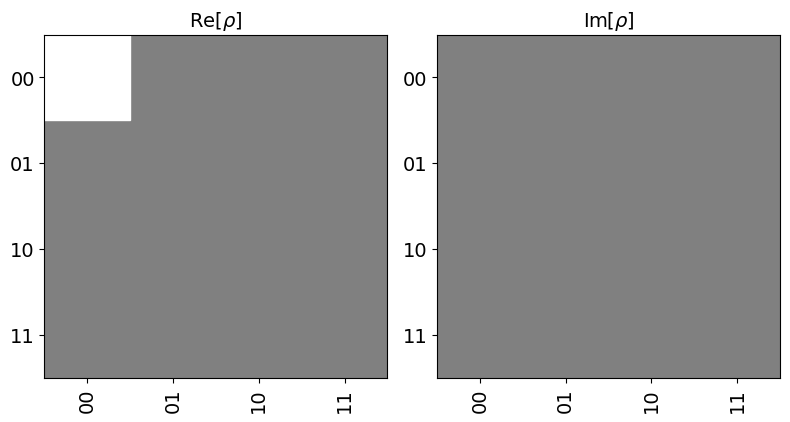

In [28]:
rho_ideal.draw(output='hinton')

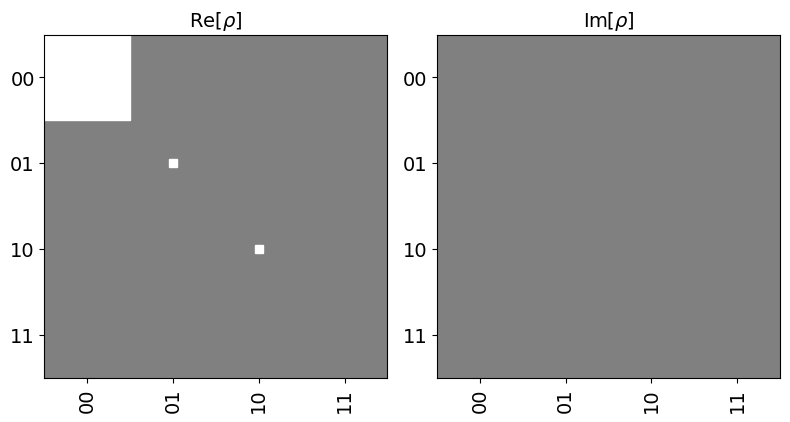

In [29]:
rho_sim.draw(output='hinton')